In [ ]:
#default_exp core.signal

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *
import torchaudio

from IPython.display import display, Audio
from librosa.display import waveplot

# Audio Signals
> Load audio signals from files into semantic torch tensors

## AudioGetter

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get audio files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_audio_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
#export
URLs.SPEAKERS10 = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz'
URLs.SPEAKERS250 = 'https://public-datasets.fra1.digitaloceanspaces.com/250-speakers.tar'
URLs.ESC50 = 'https://github.com/karoldvl/ESC-50/archive/master.zip'

In [ ]:
#export
def tar_extract_at_filename(fname, dest):
    "Extract `fname` to `dest`/`fname`.name folder using `tarfile`"
    dest = Path(dest)/Path(fname).with_suffix('').name
    tarfile.open(fname, 'r:gz').extractall(dest)

In [ ]:
p = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [ ]:
p.ls()

(#3843) [Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00001.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00002.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00003.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00004.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00005.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00006.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00007.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00008.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00009.wav'),Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00010.wav')...]

In [ ]:
audio_getter = AudioGetter("", recurse=True, folders=None)

In [ ]:
files = audio_getter(p)

In [ ]:
#files will load differently on different machines so we specify examples by name
ex_files = [p/f for f in ['m0005_us_m0005_00218.wav', 
                                'f0003_us_f0003_00279.wav', 
                                'f0001_us_f0001_00168.wav', 
                                'f0005_us_f0005_00286.wav',]]

## AudioTensor

In [ ]:
#export
class AudioTensor(TensorBase):
    @classmethod
    @delegates(torchaudio.load, keep=True)
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn, **kwargs)
        return cls(sig, sr=sr)
    
    @property
    def sr(self): return self.get_meta('sr')
    
    def __new__(cls, x, sr, **kwargs):
        return super().__new__(cls, x, sr=sr, **kwargs)
    
    # This one should probably use set_meta() but there is no documentation,
    # and I could not get it to work. Even TensorBase.set_meta?? is pointing
    # to the wrong source because of fastai patch on Tensorbase to retain types
    @sr.setter
    def sr(self, val): self._meta['sr'] = val
    
    nsamples, nchannels = add_props(lambda i, self: self.shape[-1*(i+1)])
    @property
    def duration(self): return self.nsamples/float(self.sr)
    
    def hear(self):
        display(Audio(self, rate=self.sr))
    def show(self, ctx=None, hear=True, **kwargs):
        "Show audio clip using `merge(self._show_args, kwargs)`"
        if hear: self.hear()
        show_audio_signal(self, ctx=ctx, **kwargs)
        plt.show()

Patch on indexing to retain the AudioTensor type, so when indexing it stays the same type

In [ ]:
#export
def _get_f(fn):
    def _f(self, *args, **kwargs):
        cls = self.__class__
        res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
        return retain_type(res, self)
    return _f
setattr(AudioTensor, '__getitem__', _get_f('__getitem__'))

In [ ]:
AudioTensor(torch.ones(10), sr=100)

AudioTensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
#export
def show_audio_signal(ai, ctx, **kwargs):
    if(ai.nchannels > 1):
        _,axs = plt.subplots(ai.nchannels, 1, figsize=(6,4*ai.nchannels))
        for i,channel in enumerate(ai):
            waveplot(channel.numpy(), ai.sr, ax=axs[i], **kwargs)
    else:
        axs = plt.subplots(ai.nchannels, 1)[1] if ctx is None else ctx 
        waveplot(ai.squeeze(0).numpy(), ai.sr, ax=axs, **kwargs)

In [ ]:
item0 = AudioTensor.create(ex_files[0])

In [ ]:
item0.shape

torch.Size([1, 58240])

In [ ]:
item0.sr, item0.nchannels, item0.nsamples, item0.duration

(16000, 1, 58240, 3.64)

In [ ]:
test_eq(type(item0.data), torch.Tensor)
test_eq(item0.sr, 16000)
test_eq(item0.nchannels, 1)
test_eq(item0.nsamples, 58240)
test_eq(item0.duration, 3.64)

In [ ]:
item0[0]

AudioTensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -9.1553e-05,
        -6.1035e-05,  0.0000e+00])

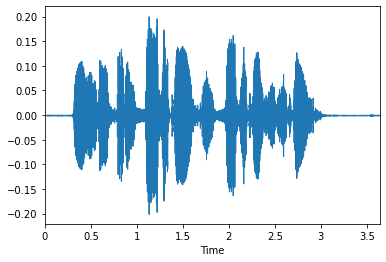

In [ ]:
item0.show()

In [ ]:
item1 = AudioTensor.create(files[1]);

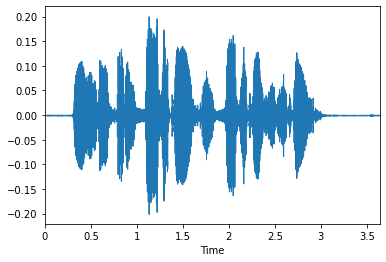

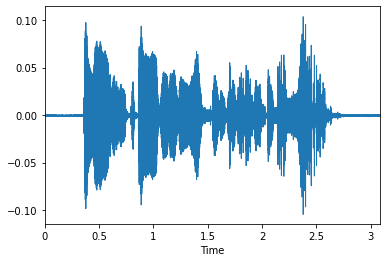

In [ ]:
item0.show()
item1.show()

In [ ]:
#get 3 equal length portions of 3 different signals so we can stack them
#for a fake multichannel example
ai0, ai1, ai2 = map(AudioTensor.create, ex_files[1:4]);
min_samples = min(ai0.nsamples, ai1.nsamples, ai2.nsamples)
s0, s1, s2 = map(lambda x: x[:,:min_samples], (ai0, ai1, ai2))

In [ ]:
tst0 = AudioTensor(torch.ones(10), sr=120)
tst1 = AudioTensor(torch.ones(10), sr=150)
(tst0 + tst1).sr

120

In [ ]:
test_eq(s0.shape, s1.shape)
test_eq(s1.shape, s2.shape)

In [ ]:
fake_multichannel = AudioTensor(torch.stack((s0, s1, s2), dim=1).squeeze(0), sr=16000)

In [ ]:
test_eq(fake_multichannel.nchannels, 3)
test_eq(fake_multichannel.nsamples, 53760)

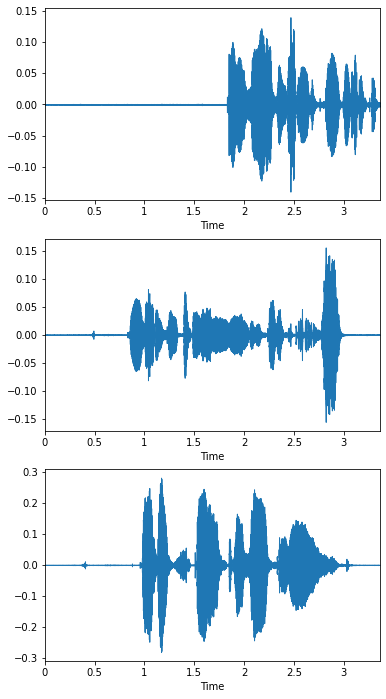

In [ ]:
fake_multichannel.show()

In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioTensor.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: (object,object) -> encodes (object,object) -> decodes

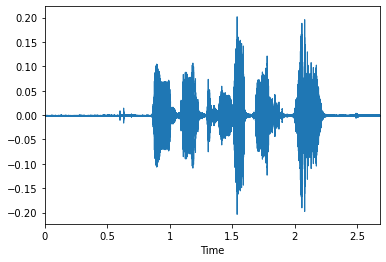

In [ ]:
#demonstrate functionality of OpenAudio.encodes, the rest of the nb will
#use files that are opened by name for reproducibility/testing
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()

In [ ]:
#test open audio on a random set of files
for i in range(10):
    idx = random.randint(0, len(files)-1)
    test_eq_type(oa.encodes(idx), AudioTensor.create(files[idx]))
    test_eq_type(oa.decodes(idx), files[idx])

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
oa.encodes(0)

AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4414e-04,
         -1.8311e-04, -6.1035e-05]])

In [ ]:
oa.decodes(0)

Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00001.wav')

In [ ]:
oa.items[0]

Path('/home/scart/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00001.wav')

# AudioBlock

In [ ]:
#export
def AudioBlock(cls=AudioTensor): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()